In [1]:
from config import *
from nms import nms
from VOCap import VOCap
from scipy.spatial.distance import cdist
import scipy.io as sio
from comptScores import comptScores
import h5py
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
category = 'car'
set_type = 'test'

img_dir = Dataset['img_dir_org'].format(category)

filelist = Dataset['{}_list'.format(set_type)].format(category)
with open(filelist, 'r') as fh:
    contents = fh.readlines()

if set_type == 'occ':
    img_list = [cc.strip()[0:-2] for cc in contents if cc != '\n']
    idx_list = [cc.strip()[-1] for cc in contents if cc != '\n']
else:
    img_list = [cc.strip().split()[0] for cc in contents if cc != '\n']
    idx_list = [cc.strip().split()[1] for cc in contents if cc != '\n']
    
    
file_cache_rr = os.path.join(Feat['cache_dir'], 'feat_{}_{}_rr.pickle'.format(category, set_type))
with open(file_cache_rr, 'rb') as fh:
    resize_ratio_ls = pickle.load(fh)
    
with open('/mnt/1TB_SSD/qing/SP/debug.pickle', 'rb') as fh:
    score_map_o, spanno_all, img_size = pickle.load(fh)
    
N = 2000
sp_num = 41


In [13]:
pp = 34
score_map_rich = [score_map_o[nn][:,:,pp] - np.max(score_map_o[nn][:,:,np.arange(sp_num)!=pp], axis=2) for nn in range(N)]
score_map_bg = [score_map_o[nn][:,:,pp] - np.max(score_map_o[nn][:,:,[-2,-1]], axis=2) for nn in range(N)]
score_map_sp = [score_map_o[nn][:,:,pp] for nn in range(N)]

score_map = [score_map_o[nn][:,:,pp] - \
             0.5*np.max(score_map_o[nn][:,:,np.arange(sp_num)!=pp], axis=2) - \
             0.5*np.max(score_map_o[nn][:,:,[-2,-1]], axis=2) for nn in range(N)]
# score_map_b1 = [score_map_o[nn][:,:,-2] for nn in range(N)]
# score_map_b2 = [score_map_o[nn][:,:,-1] for nn in range(N)]
spanno = [spanno_all[nn][pp] for nn in range(N)]

N = len(score_map_rich)
sp_detection = np.zeros((0,6))
for nn in range(N):
    # det = score_map[nn][:,:,pp] - score_map[nn][:,:,-1]
#     det_rich = score_map_rich[nn].copy()
#     det_bg = score_map_bg[nn].copy()
#     det_sp = score_map_sp[nn].copy()
    
    det = score_map[nn].copy()
    
    [r_list, c_list] = np.unravel_index(range(det.shape[0]*det.shape[1]), (det.shape[0], det.shape[1]))
    # image level
    r_list = (8.0 * r_list + 7.5 + 1.0)
    c_list = (8.0 * c_list + 7.5 + 1.0)
    det = det.ravel()
    # det_sp = det_sp.ravel()

    # nms_thresh = np.min(det) + (np.max(det) - np.min(det)) * SP['NMS_score_ratio']
    nms_thresh = np.percentile(det, 90)
    r_list = r_list[det >= nms_thresh]
    c_list = c_list[det >= nms_thresh]
    # det_sp = det_sp[det >= nms_thresh]
    det = det[det >= nms_thresh]
    
    # enhance samples with highest SP score
#     sort_idx_det = np.argsort(-det)
#     max_det_sp = np.max(det_sp[sort_idx_det[0:10]])
#     max_idx_det_sp = np.argmax(det_sp[sort_idx_det[0:5]])
#     det[sort_idx_det[max_idx_det_sp]] += 15

    bb_loc = np.column_stack((c_list-49.5, r_list-49.5, c_list+49.5, r_list+49.5, det))
    nms_list = nms(bb_loc, 0.05)
    bb_loc_ = np.concatenate((np.ones((len(nms_list), 1))*nn, bb_loc[nms_list]), axis=1)
    sp_detection = np.concatenate((sp_detection, bb_loc_), axis=0)

kp_pos = np.sum([spanno[nn].shape[0] for nn in range(N)])

tot = sp_detection.shape[0]
sort_idx = np.argsort(-sp_detection[:,5])
det_list = sp_detection[:,5][sort_idx]

id_list = sp_detection[sort_idx, 0]
col_list = (sp_detection[sort_idx, 1]+sp_detection[sort_idx, 3])/2
row_list = (sp_detection[sort_idx, 2]+sp_detection[sort_idx, 4])/2
bbox_list = sp_detection[sort_idx, 1:5].astype(int)

In [11]:
def get_next_fp(flag, dd_start):
    for dd in range(dd_start, tot):
        img_id = int(id_list[dd])
        col_c = col_list[dd]
        row_c = row_list[dd]
        bb_c = bbox_list[dd]
        inst = spanno[img_id]
        if SP['criteria'] == 'dist':
            min_dist = np.inf
            for ii in range(inst.shape[0]):
                xx = (inst[ii,0]+inst[ii,2])/2
                yy = (inst[ii,1]+inst[ii,3])/2

                if np.sqrt((xx-col_c)**2+(yy-row_c)**2) < min_dist:
                    min_dist = np.sqrt((xx-col_c)**2+(yy-row_c)**2)
                    min_idx = ii

            if min_dist < SP['dist_thresh'] and flag[img_id, min_idx] == 0:
                flag[img_id, min_idx]=1
            else:
                print(det_list[dd], min_dist, flag[img_id, min_idx])
                return (flag, dd, img_id, bb_c)

        elif SP['criteria'] == 'iou':
            max_iou = -np.inf
            for ii in range(inst.shape[0]):
                bbgt = inst[ii]
                
                bb_c = np.array([max(np.ceil(bb_c[0]),1), max(np.ceil(bb_c[1]),1), \
                               min(np.floor(bb_c[2]), img_size[img_id][1]),  min(np.floor(bb_c[3]), img_size[img_id][0])])

                bi = [max(bb_c[0], bbgt[0]), max(bb_c[1], bbgt[1]), min(bb_c[2], bbgt[2]), min(bb_c[3], bbgt[3])]
                iw = bi[2]-bi[0]+1
                ih = bi[3]-bi[1]+1

                if iw>0 and ih>0:
                    ua = (bb_c[2]-bb_c[0]+1)*(bb_c[3]-bb_c[1]+1)+\
                         (bbgt[2]-bbgt[0]+1)*(bbgt[3]-bbgt[1]+1)-\
                         iw*ih
                    ov = iw*ih/ua
                    if ov>max_iou:
                        max_iou = ov
                        max_idx = ii

            if max_iou > SP['iou_thresh'] and flag[img_id, max_idx] == 0:
                flag[img_id, max_idx]=1
            else:
                print(det_list[dd], max_iou, flag[img_id, max_idx])
                return (flag, dd, img_id, bb_c)
            

In [22]:
# flag = np.zeros((N,20))
# dd = -1
flag, dd, img_id, bb = get_next_fp(flag,dd+1)
print(dd)

1034.08789062 0.423487544484 0.0
65


(375, 539, 3)


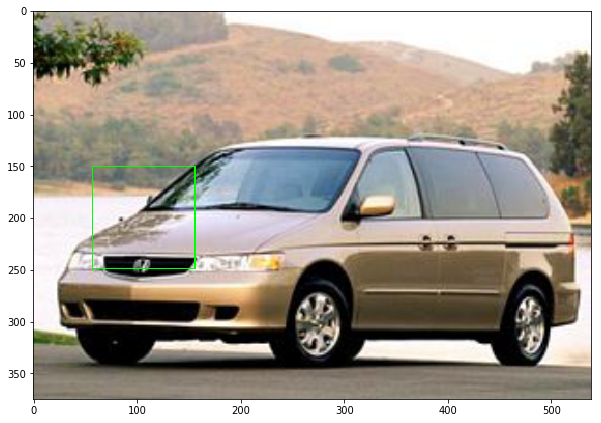

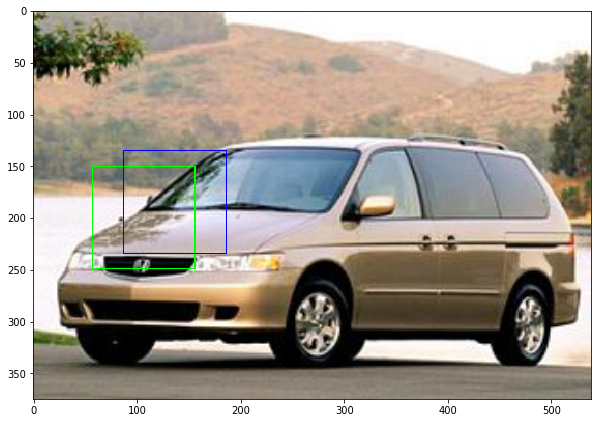

In [23]:
nn = img_id

img = cv2.imread(os.path.join(img_dir, '{}.JPEG'.format(img_list[nn])))
img = cv2.resize(img, (0,0), fx=resize_ratio_ls[nn], fy=resize_ratio_ls[nn])
print(img.shape)

inst = spanno[nn]
for ii in range(inst.shape[0]):
    bbgt = inst[ii].astype(int)
    cv2.rectangle(img, (bbgt[0], bbgt[1]), (bbgt[2], bbgt[3]), [0,255,0])

plt.imshow(img[:,:,::-1])
plt.show()

bb = np.array([max(np.ceil(bb[0]),1), max(np.ceil(bb[1]),1), \
               min(np.floor(bb[2]), img_size[nn][1]),  min(np.floor(bb[3]), img_size[nn][0])]).astype(int)

cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), [255,0,0])
    
plt.imshow(img[:,:,::-1])
plt.show()

(375, 539, 3)


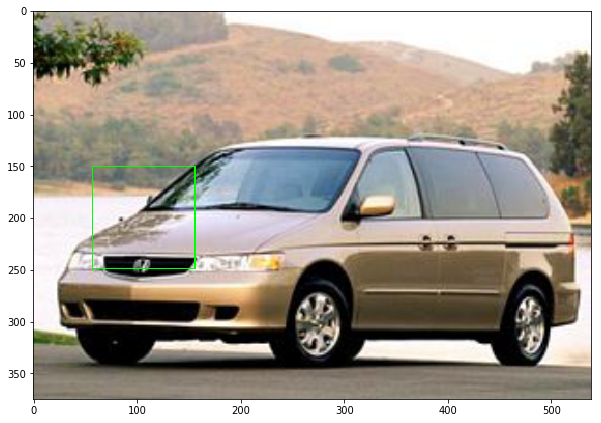

1034.08789062 -3815.68310547
969.789306641 -3554.09667969


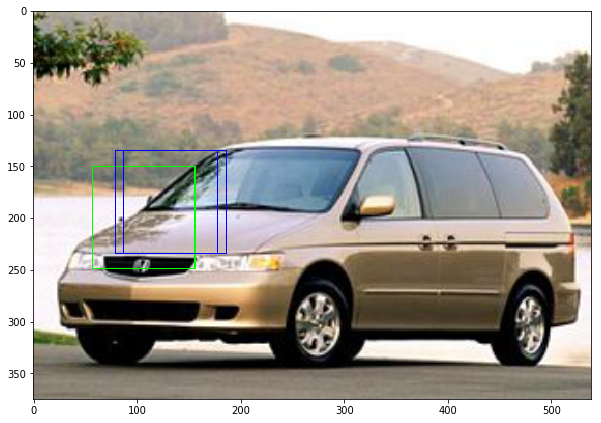

In [24]:
img = cv2.imread(os.path.join(img_dir, '{}.JPEG'.format(img_list[nn])))
img = cv2.resize(img, (0,0), fx=resize_ratio_ls[nn], fy=resize_ratio_ls[nn])
print(img.shape)

det = score_map[nn].copy()
det_sp = score_map_sp[nn].copy().ravel()
# det_b1 = score_map_b1[nn].copy().ravel()
# det_b2 = score_map_b2[nn].copy().ravel()
[r_list_o, c_list_o] = np.unravel_index(range(det.shape[0]*det.shape[1]), (det.shape[0], det.shape[1]))
# image level
r_list_o = (8.0 * r_list_o + 7.5 + 1.0)
c_list_o = (8.0 * c_list_o + 7.5 + 1.0)
det = det.ravel()

# nms_thresh = np.min(det) + (np.max(det) - np.min(det)) * SP['NMS_score_ratio']
nms_thresh = np.percentile(det, 90)
r_list_o = r_list_o[det >= nms_thresh]
c_list_o = c_list_o[det >= nms_thresh]
det_sp = det_sp[det >= nms_thresh]
# det_b1 = det_b1[det >= nms_thresh]
# det_b2 = det_b2[det >= nms_thresh]
det = det[det >= nms_thresh]
bbox_list_o = np.column_stack((c_list_o-49.5, r_list_o-49.5, c_list_o+49.5, r_list_o+49.5))

# bb_loc = np.column_stack((c_list-49.5, r_list-49.5, c_list+49.5, r_list+49.5, det))
# nms_list = nms(bb_loc, 0.05)
# det = det[nms_list]
# bbox_list = bb_loc[nms_list][0:4]

inst = spanno[nn]
for ii in range(inst.shape[0]):
    bbgt = inst[ii].astype(int)
    cv2.rectangle(img, (bbgt[0], bbgt[1]), (bbgt[2], bbgt[3]), [0,255,0])

plt.imshow(img[:,:,::-1])
plt.show()

idx_s = np.argsort(-det)
ids_s2 = np.argsort(-det_sp[idx_s[0:10]])
for ddi in idx_s[[0,ids_s2[0]]]:
# for ddi in idx_s[0:1]:
    print(det[ddi], det_sp[ddi])
    bb = bbox_list_o[ddi]
    bb = np.array([max(np.ceil(bb[0]),1), max(np.ceil(bb[1]),1), \
                   min(np.floor(bb[2]), img_size[nn][1]),  min(np.floor(bb[3]), img_size[nn][0])]).astype(int)

    cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), [255,0,0])
    
plt.imshow(img[:,:,::-1])
plt.show()

In [20]:
np.sum(flag)

70.0

In [20]:
nn

78